# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_egemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_egemaps_features = df_essentia_best_overall_opensmile_egemaps_features[df_essentia_best_overall_opensmile_egemaps_features.columns[1:]]

df_essentia_best_overall_opensmile_egemaps_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,2,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,3,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,4,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,5,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,7,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,1997,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,1998,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,1999,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [4]:
df_essentia_best_overall_opensmile_egemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 225 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.dmean                float64
 2    lowlevel.melbands_kurtosis.dmean2               float64
 3    lowlevel.melbands_kurtosis.dvar                 float64
 4    lowlevel.melbands_kurtosis.dvar2                float64
 5    lowlevel.melbands_kurtosis.max                  float64
 6    lowlevel.melbands_kurtosis.mean                 float64
 7    lowlevel.melbands_kurtosis.median               float64
 8    lowlevel.melbands_kurtosis.min                  float64
 9    lowlevel.melbands_kurtosis.stdev                float64
 10   lowlevel.melbands_kurtosis.var                  float64
 11   lowlevel.melbands_skewness.dmean                float64
 12   lowlevel.melbands_

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_egemaps_whole = pd.merge(df_essentia_best_overall_opensmile_egemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_egemaps_whole = df_essentia_best_overall_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_egemaps_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429,-0.475,-0.500
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348,-0.375,-0.425
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370,0.175,0.125
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132,-0.150,0.075
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006,-0.275,0.225
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482,0.075,-0.275
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258,0.350,0.300
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_egemaps_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 300

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 224])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Epoch 3, Loss: 0.5761741250204345
Epoch 4, Loss: 0.5741147057349343
Epoch 5, Loss: 0.5721365617113515
Epoch 6, Loss: 0.5702758934082562
Epoch 7, Loss: 0.5685027423430153
Epoch 8, Loss: 0.566825842823665
Epoch 9, Loss: 0.5652521411394601
Epoch 10, Loss: 0.563788289759631
Epoch 11, Loss: 0.5625192850833634
Epoch 12, Loss: 0.5613398243448778
Epoch 13, Loss: 0.5602677610697959
Epoch 14, Loss: 0.5593127178703665
Epoch 15, Loss: 0.5584875419323488
Epoch 16, Loss: 0.5577950536313002
Epoch 17, Loss: 0.557226655560956
Epoch 18, Loss: 0.5567881338526075
Epoch 19, Loss: 0.5564751094553915
Epoch 20, Loss: 0.5562752578658635
Epoch 21, Loss: 0.5561803688443486
Epoch 22, Loss: 0.5561787077404596
Epoch 23, Loss: 0.556246433889552
Epoch 24, Loss: 0.5563595781727941
Epoch 25, Loss: 0.5564911491070637
Epoch 26, Loss: 0.5566189678061456
Epoch 27, Loss: 0.5567247293746999
Epoch 28, Loss: 0.5567958146983457
Epoch 29, Loss: 0.556828169432331

Epoch 84, Loss: 0.49069857561990354
Epoch 85, Loss: 0.48934635724058206
Epoch 86, Loss: 0.4878690429263216
Epoch 87, Loss: 0.48654395220616825
Epoch 88, Loss: 0.48566033962592914
Epoch 89, Loss: 0.4850410834589303
Epoch 90, Loss: 0.48428993093352457
Epoch 91, Loss: 0.4833370285331397
Epoch 92, Loss: 0.4822832286692537
Epoch 93, Loss: 0.4813521103470029
Epoch 94, Loss: 0.4806314363532306
Epoch 95, Loss: 0.48003657993863913
Epoch 96, Loss: 0.4794024288283065
Epoch 97, Loss: 0.47861675828605904
Epoch 98, Loss: 0.4777865870243367
Epoch 99, Loss: 0.47704440906216294
Epoch 100, Loss: 0.47641967759519066
Epoch 101, Loss: 0.47582362695649294
Epoch 102, Loss: 0.4752102098117133
Epoch 103, Loss: 0.4745441439035258
Epoch 104, Loss: 0.4738826603965868
Epoch 105, Loss: 0.47327773164969655
Epoch 106, Loss: 0.4727329318053382
Epoch 107, Loss: 0.47221475268826657
Epoch 108, Loss: 0.47174068712018924
Epoch 109, Loss: 0.47151383352971166
Epoch 110, Loss: 0.4718719785479892
Epoch 111, Loss: 0.47120182638

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 224])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.20604686518868384
Valence RMSE: 0.18816029277735652
Arousal RMSE: 0.22250016973051231
Test R^2 score: tensor([0.5709, 0.5098], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-0.2041, -0.3757], dtype=torch.float64)
Test R^2 score (overall): 0.5403698412067337


In [21]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_overall_opensmile_egemaps_normalised.pt')

True values (test set)

In [21]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 3.6677e-02,  2.4239e-02],
        [-3.1454e-01, -3.7808e-01],
        [ 3.5930e-01,  3.5434e-01],
        [ 1.6355e-01,  1.7294e-01],
        [-5.1985e-02, -8.5008e-02],
        [-2.5150e-01, -3.0523e-01],
        [-3.9484e-01, -4.7094e-01],
        [ 2.9845e-01,  3.0989e-01],
        [-3.3114e-01, -3.9728e-01],
        [ 2.1109e-01,  2.2756e-01],
        [ 2.4526e-01,  2.6437e-01],
        [-1.1940e-01, -1.5877e-01],
        [-2.7626e-01, -3.3386e-01],
        [ 3.1533e-01,  3.2331e-01],
        [-1.4502e-01, -1.8677e-01],
        [ 3.0276e-03, -1.8886e-02],
        [-4.0411e-01, -4.8164e-01],
        [-1.0597e-01, -1.4409e-01],
        [ 1.9474e-01,  2.0979e-01],
        [-1.6269e-01, -2.0602e-01],
        [-3.2124e-01, -3.8584e-01],
        [-1.6353e-01, -2.0695e-01],
        [-2.8289e-01, -3.4148e-01],
        [ 2.5736e-01,  2.7812e-01],
        [ 1.0581e-01,  1.0571e-01],
        [-7.2213e-02, -1.0720e-01],
        [ 3.2090e-01,  3.2622e-01],
        [ 1.3011e-01,  1.339

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5805225147182124
Training completed.
Training completed.
Testing model...
Test RMSE: 0.33670436629551814
Valence RMSE: 0.3341304300076685
Arousal RMSE: 0.3392587748427791
Test Adjusted R^2 score: tensor([-2.7971, -2.1984], dtype=torch.float64)
Test R^2 score: -0.24632585261507545
Num of epochs: 2
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3338621054695041
Valence RMSE: 0.33022574031356855
Arousal RMSE: 0.33745928846516615
Test Adjusted R^2 score: tensor([-2.7089, -2.1645], dtype=torch.float64)
Test R^2 score: -0.22457802000026905
Num of epochs: 3
Epoch 1, Loss: 0.5805225147182124
Epoch 2, Loss: 0.5783089267855728
Epoch 3, Loss: 0.5761741250204345
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3311056303759994
Valence RMSE: 0.3264284473020484
Arousal RMSE: 0.33571765775030304
Test Adjusted R^2 score: tensor([-2.6241, -2.1319], dtype=torc

### Plot graphs to visualise relationship between the evaluation metrics

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

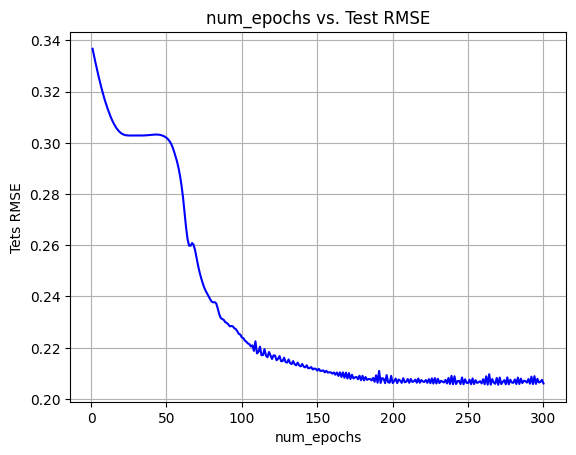

In [26]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [27]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.20551823921919735
Corresponding R^2 SCore: 0.5426639412798423
Corresponding num_epochs: 270


#### Test R^2 Score vs. num_epochs

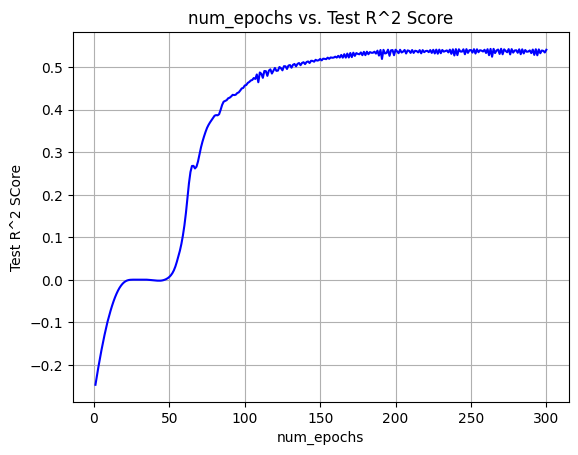

In [28]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [29]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5426639412798423
Corresponding RMSE: 0.20551823921919735
Corresponding num_epochs: 270


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

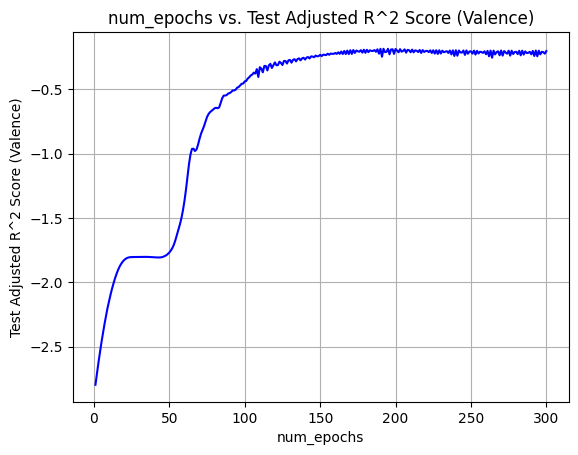

In [30]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -0.18629705249016082
Corresponding RMSE: 0.20623483081782998
Corresponding num_epochs: 192


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

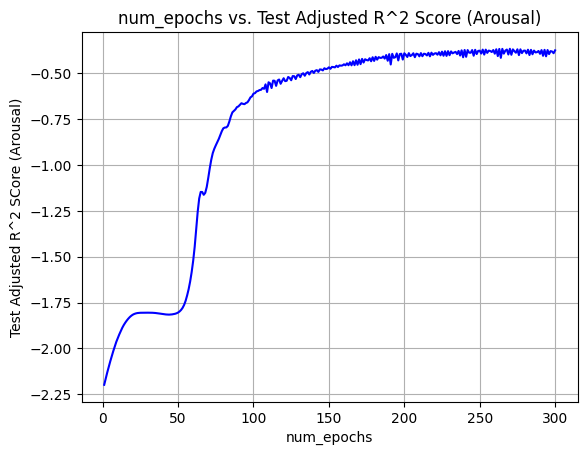

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -0.3671245683503239
Corresponding RMSE: 0.20551823921919735
Corresponding num_epochs: 270
